# Final Project: Classifying Brain Tumors
Data from [Kaggle: brain_tumor_dataset](https://www.kaggle.com/datasets/balamosay/brain-tumor-dataset).

Classes
- 0 = glioma
- 1 = meningioma
- 2 = no tumor
- 3 = pituitary

## Import Packages

In [1]:
from os import environ
environ['TF_DISABLE_NUMA_SUPPORT'] = '1'

In [2]:
import sys
import math
import pathlib
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from os import makedirs, listdir, path
from shutil import copyfile, move
from random import seed, random
from matplotlib import pyplot
from keras.utils import to_categorical, img_to_array
from keras.models import Sequential, load_model, Model
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import load_img
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Rescaling, Dropout, Input, RandomRotation, RandomFlip
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import InceptionV3

2024-10-17 21:34:26.533601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 21:34:26.545481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 21:34:26.548858: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 21:34:26.557955: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 21:34:27.313637: W tensorflow/compiler/tf2

## Load in Data
- No Tumor: 200-250
- Others: 512x512

In [3]:
root = 'datasets/tumors'
current_dir = pathlib.Path.cwd().parent
combined = current_dir / root

In [4]:
batch_size = 64
img_height = 224
img_width = 224
num_classes = 3
dense_activation = 'softmax'
input_shape = (img_height, img_width, 3)

In [5]:
# https://www.tensorflow.org/tutorials/load_data/images#standardize_the_data
train_ds = image_dataset_from_directory(
    combined / 'Training',
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

test_ds = image_dataset_from_directory(
    combined / 'Testing',
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 2044 files belonging to 3 classes.


I0000 00:00:1729215268.296888  464837 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729215268.311946  464837 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729215268.312004  464837 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729215268.314047  464837 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729215268.314099  464837 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Found 294 files belonging to 3 classes.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Setup Utility Functions

In [7]:
# Plot diagnostic learning curves
def plot_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    pyplot.show()
    pyplot.close() 
    
# Run test harness for a trained model 
def test_harness(model, epochs = 10, train_ds = train_ds, test_ds = test_ds):
    # fit model
    history = model.fit(train_ds, validation_data = test_ds, epochs = epochs, verbose = 1)
    # evaluate model
    _, acc = model.evaluate(test_ds, steps=len(test_ds), verbose=2)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    plot_diagnostics(history)

    return model

## One Block SGD VGG Model

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.4804 - loss: 4.5415 - val_accuracy: 0.3707 - val_loss: 1.1587
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7526 - loss: 0.7541 - val_accuracy: 0.4422 - val_loss: 1.1803
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8478 - loss: 0.4402 - val_accuracy: 0.5782 - val_loss: 1.0427
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8901 - loss: 0.3285 - val_accuracy: 0.6088 - val_loss: 0.9074
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9036 - loss: 0.2836 - val_accuracy: 0.6395 - val_loss: 0.8031
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9182 - loss: 0.2499 - val_accuracy: 0.6837 - val_loss: 0.7197
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9280 - loss: 0.2205 - val_accuracy: 0.7143 - val_loss: 0.6500
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9428 - loss: 0.1961 - val_accuracy: 0.7585 - 

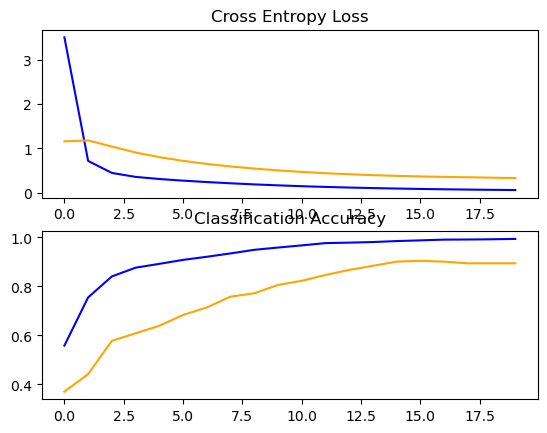

In [73]:
def one_block():
    model = Sequential([
        Input(shape=input_shape),
        # Rescale images to [0, 1] range
        Rescaling(1./255),
    	Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D(),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])
    
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss=SparseCategoricalCrossentropy, metrics=['accuracy'])

    return model

one_block_res = test_harness(one_block(), 20)

## One Block Adam VGG Model

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.4684 - loss: 16.8215 - val_accuracy: 0.4660 - val_loss: 9.7133
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8177 - loss: 1.2977 - val_accuracy: 0.4626 - val_loss: 4.4649
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8720 - loss: 0.4856 - val_accuracy: 0.6224 - val_loss: 2.1510
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9193 - loss: 0.3694 - val_accuracy: 0.7279 - val_loss: 1.5270
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9366 - loss: 0.1997 - val_accuracy: 0.9048 - val_loss: 0.4637
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9927 - loss: 0.0362 - val_accuracy: 0.9320 - val_loss: 0.3727
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9970 - loss: 0.0122 - val_accuracy: 0.9558 - val_loss: 0.3625
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9989 - loss: 0.0059 - val_accuracy: 0.9626 - 

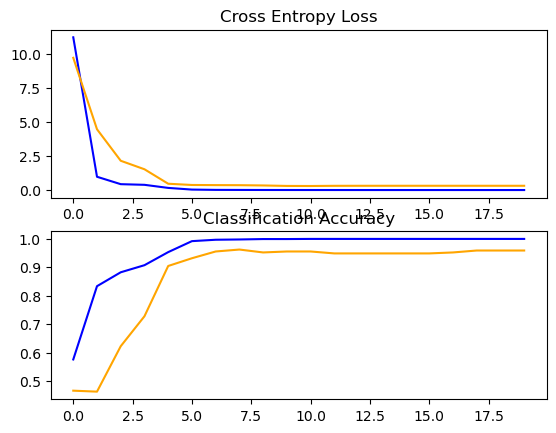

In [76]:
def one_adam():
    model = Sequential([
        Input(input_shape),
        # Rescale images to [0, 1] range
        Rescaling(1./255),
    	Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(num_classes, activation=dense_activation)
    ])

    opt = Adam()
    model.compile(optimizer=opt, loss=SparseCategoricalCrossentropy, metrics=['accuracy'])

    return model

one_adam_res = test_harness(one_adam(), 20)

## Two Block Adam VGG Model

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.4632 - loss: 19.7106 - val_accuracy: 0.3401 - val_loss: 1.2047
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6634 - loss: 0.8541 - val_accuracy: 0.5204 - val_loss: 1.0158
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8098 - loss: 0.4842 - val_accuracy: 0.6156 - val_loss: 0.9184
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8793 - loss: 0.3221 - val_accuracy: 0.6871 - val_loss: 0.6485
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9212 - loss: 0.2127 - val_accuracy: 0.7653 - val_loss: 0.5671
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9283 - loss: 0.1746 - val_accuracy: 0.8299 - val_loss: 0.4966
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9491 - loss: 0.1524 - val_accuracy: 0.8639 - val_loss: 0.4194
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9551 - loss: 0.1157 - val_accuracy: 0.8810 -

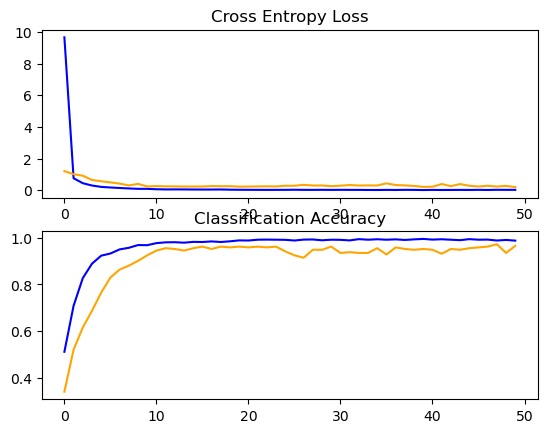

In [43]:
def two_adam():
    model = Sequential([
        Rescaling(1./255),
        
    	Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
    	Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation=dense_activation)
    ])

    opt = Adam(learning_rate=0.001)
    # opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss=SparseCategoricalCrossentropy, metrics=['accuracy'])

    return model

two_adam_res = test_harness(two_adam(), 50)

## Three Block SGD VGG Model with Dropout

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.4120 - loss: 1.3534 - val_accuracy: 0.2517 - val_loss: 1.1591
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6496 - loss: 0.8540 - val_accuracy: 0.2959 - val_loss: 1.1480
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6720 - loss: 0.8050 - val_accuracy: 0.3299 - val_loss: 1.1225
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6770 - loss: 0.7514 - val_accuracy: 0.3265 - val_loss: 1.1307
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7091 - loss: 0.7166 - val_accuracy: 0.3673 - val_loss: 1.1018
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7043 - loss: 0.7098 - val_accuracy: 0.3980 - val_loss: 1.0868
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7302 - loss: 0.6763 - val_accuracy: 0.4150 - val_loss: 1.0907
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7235 - loss: 0.6505 - val_accuracy: 0

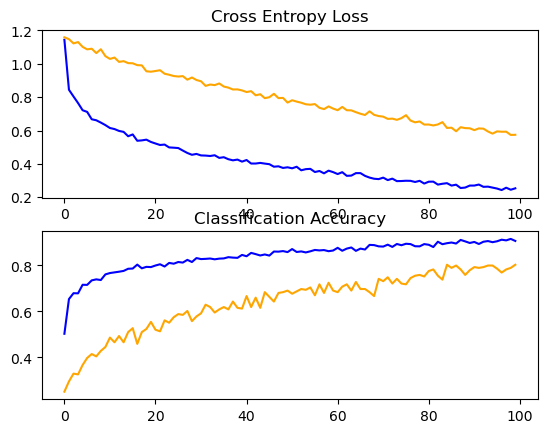

In [11]:
def three_drop_sgd():
    model = Sequential([
        Input(shape=input_shape),
        # Rescale images to [0, 1] range
        Rescaling(1./255),
        # RandomRotation(0.2),
        # RandomFlip(mode="horizontal_and_vertical"),
        
    	Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
    	Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
    	Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.6),
        Dense(num_classes, activation=dense_activation)
    ])
    
    opt = SGD(learning_rate=0.0001, momentum=0.9)
    model.compile(optimizer=opt, loss=SparseCategoricalCrossentropy, metrics=['accuracy'])

    return model

three_drop_save = test_harness(three_drop_sgd(), 100)

## Three Block ADAM VGG with Dropout

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.5023 - loss: 10.1762 - val_accuracy: 0.4626 - val_loss: 1.1755
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8022 - loss: 0.5050 - val_accuracy: 0.6735 - val_loss: 0.7660
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8884 - loss: 0.3010 - val_accuracy: 0.7687 - val_loss: 0.5656
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9137 - loss: 0.2077 - val_accuracy: 0.8571 - val_loss: 0.4163
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9413 - loss: 0.1468 - val_accuracy: 0.9150 - val_loss: 0.3016
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9759 - loss: 0.0848 - val_accuracy: 0.9252 - val_loss: 0.2672
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9736 - loss: 0.0671 - val_accuracy: 0.9388 - val_loss: 0.2191
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9799 - loss: 0.0549 - val_accuracy: 0.9184 -

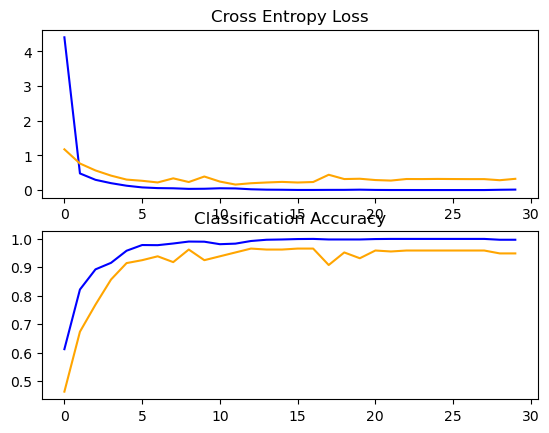

In [42]:
def three_two_layer():
    model = Sequential([
        Input(shape=input_shape),
        Rescaling(1./255),
        
    	Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.1),
                  
    	Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.1),
                  
    	Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.1),
                  
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.1),
        Dense(num_classes, activation=dense_activation)
    ])

    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss=SparseCategoricalCrossentropy, metrics=['accuracy'])

    return model

three_two_layer_result = test_harness(three_two_layer(), 30)

## ~~Three Block SGD VGG with Two Layers per block and Dropout~~

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.3612 - loss: 5.7582 - val_accuracy: 0.2030 - val_loss: 1.4076
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.4678 - loss: 1.2592 - val_accuracy: 0.2589 - val_loss: 1.6653
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.5480 - loss: 1.0327 - val_accuracy: 0.3503 - val_loss: 1.6817
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.5970 - loss: 0.9242 - val_accuracy: 0.3604 - val_loss: 1.9241
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.6316 - loss: 0.8497 - val_accuracy: 0.4061 - val_loss: 1.9760
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.6555 - loss: 0.7864 - val_accuracy: 0.4137 - val_loss: 1.9359
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.6676 - loss: 0.7642 - val_accuracy: 0.4365 - val_loss: 1.9092
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.6659 - loss: 0.7334 - val_accuracy: 0.4061 -

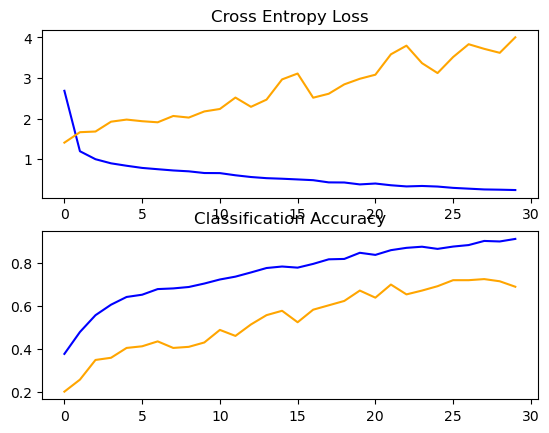

In [23]:
def three_two_layer_sgd():
    model = Sequential([
        Input(shape=input_shape),
        # Rescale images to [0, 1] range
        Rescaling(1./255),
    	Conv2D(32, (3, 3), activation='relu', padding='same'),
    	Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
                  
    	Conv2D(64, (3, 3), activation='relu', padding='same'),
    	Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
                  
    	Conv2D(128, (3, 3), activation='relu', padding='same'),
    	Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
                  
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

    return model

three_two_sgd_layer_result = test_harness(three_two_layer_sgd(), 30)

## ~~Three Block SGD VGG with Two Layers per block, Augmentation, and Dropout~~

Epoch 1/30


2024-10-15 17:56:39.846271: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_7_1/dropout_8_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.3369 - loss: 1.3705 - val_accuracy: 0.2183 - val_loss: 1.4167
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.4493 - loss: 1.2787 - val_accuracy: 0.2563 - val_loss: 1.6264
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.4888 - loss: 1.1768 - val_accuracy: 0.2513 - val_loss: 1.6636
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.5248 - loss: 1.1051 - val_accuracy: 0.2132 - val_loss: 1.7002
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.5685 - loss: 1.0157 - val_accuracy: 0.2157 - val_loss: 1.8499
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.6174 - loss: 0.9184 - val_accuracy: 0.2335 - val_loss: 2.0774
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.6419 - loss: 0.8737 - val_accuracy: 0.2944 - val_loss: 2.1803
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.6525 - loss: 0.8431 - val_accuracy: 0.3198 - val_loss:

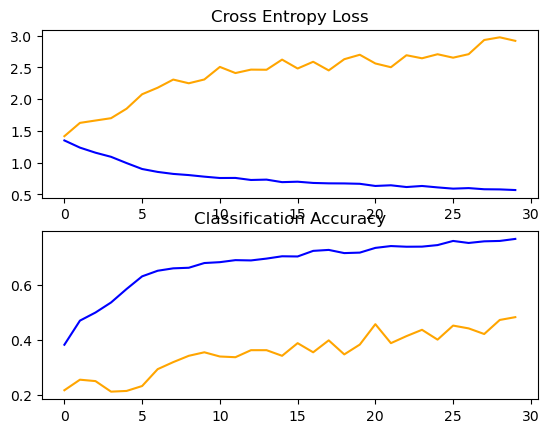

In [20]:
def three_two_augment():
    model = Sequential([
        Input(shape=input_shape),
        # Rescale images to [0, 1] range
        Rescaling(1./255),
        RandomRotation(0.1),
        RandomFlip(mode="horizontal"),
        
    	Conv2D(32, (3, 3), activation='relu', padding='same'),
    	Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
                  
    	Conv2D(64, (3, 3), activation='relu', padding='same'),
    	Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
                  
    	Conv2D(128, (3, 3), activation='relu', padding='same'),
    	Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
                  
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

    return model

three_two_sgd_augment_res = test_harness(three_two_augment(), 30)

## Transfer Learning with VGG16

In [ ]:
# train_rgb = image_dataset_from_directory(
#     combined / 'Training',
#     image_size=(img_height, img_width),
#     batch_size=batch_size,
# )

# test_rgb = image_dataset_from_directory(
#     combined / 'Testing',
#     image_size=(img_height, img_width),
#     batch_size=batch_size,
# )

def augment_preprocess(image, label):
    # Rotate 90deg
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # Flip left/right
    # image = tf.image.random_flip_left_right(image)
    # Run through VGG16 preprocessor
    return (preprocess_input(image), label)

train_rgb = train_ds.map(augment_preprocess, num_parallel_calls=AUTOTUNE)
test_rgb = test_ds.map(augment_preprocess, num_parallel_calls=AUTOTUNE)

train_rgb = train_rgb.cache().prefetch(buffer_size=AUTOTUNE)
test_rgb = test_rgb.cache().prefetch(buffer_size=AUTOTUNE)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.6634 - loss: 22.9460 - val_accuracy: 0.8265 - val_loss: 0.9285
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9077 - loss: 0.4455 - val_accuracy: 0.8639 - val_loss: 0.5799
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9404 - loss: 0.1702 - val_accuracy: 0.9150 - val_loss: 0.3648
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9622 - loss: 0.1019 - val_accuracy: 0.8980 - val_loss: 0.3569
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9740 - loss: 0.0754 - val_accuracy: 0.9116 - val_loss: 0.4572
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9742 - loss: 0.0722 - val_accuracy: 0.9218 - val_loss: 0.3234
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9795 - loss: 0.0554 - val_accuracy: 0.9218 - val_loss: 0.3071
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9837 - loss: 0.0417 - val_accuracy: 0

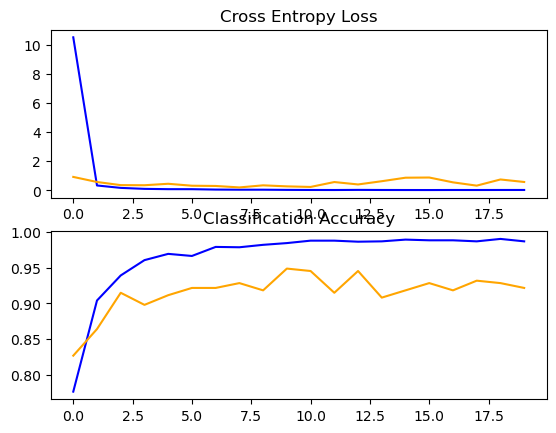

In [27]:
def transfer():
    # https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4
    ## Loading VGG16 model
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False ## Not trainable weights

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

    opt = Adam()
    # opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss=SparseCategoricalCrossentropy, metrics=['accuracy'])
    
    return model
    
transfer_res = test_harness(transfer(), 20, train_rgb, test_rgb)

## Transfer Learning with InceptionV3

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.5028 - loss: 27.5228 - val_accuracy: 0.6429 - val_loss: 1.0310
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.8664 - loss: 0.3729 - val_accuracy: 0.8503 - val_loss: 0.5191
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9460 - loss: 0.1724 - val_accuracy: 0.8844 - val_loss: 0.3474
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9627 - loss: 0.0942 - val_accuracy: 0.7585 - val_loss: 0.7199
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9426 - loss: 0.1270 - val_accuracy: 0.8503 - val_loss: 0.3688
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9649 - loss: 0.1012 - val_accuracy: 0.8571 - val_loss: 0.6053
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9765 - loss: 0.0721 - val_accuracy: 0.9354 - val_loss: 0.2794
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9883 - loss: 0.0245 - val_accuracy: 0

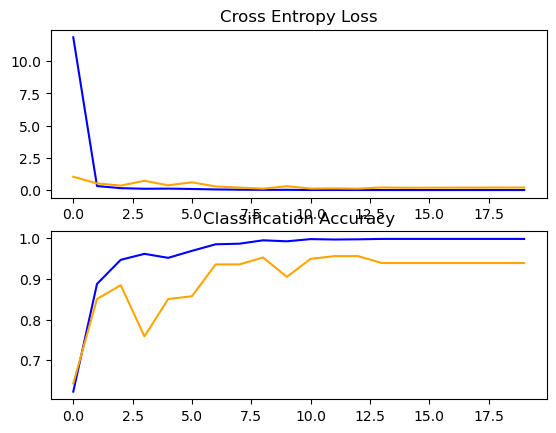

In [25]:
def inception():
    base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False ## Not trainable weights

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.6),
        Dense(num_classes, activation='softmax')
    ])

    opt = Adam()
    # opt = Adam(learning_rate=0.0001)
    # opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss=SparseCategoricalCrossentropy, metrics=['accuracy'])
    
    return model

inception_res = test_harness(transfer(), 20)

## Selected Model: Two Block Adam VGG Model (100 epochs)

Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.4572 - loss: 10.4981 - val_accuracy: 0.3503 - val_loss: 1.1800
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7322 - loss: 0.8081 - val_accuracy: 0.5170 - val_loss: 1.0445
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8215 - loss: 0.4800 - val_accuracy: 0.6122 - val_loss: 0.8423
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8841 - loss: 0.3075 - val_accuracy: 0.6803 - val_loss: 0.6606
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9150 - loss: 0.2095 - val_accuracy: 0.7449 - val_loss: 0.5810
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9443 - loss: 0.1463 - val_accuracy: 0.7857 - val_loss: 0.5406
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9481 - loss: 0.1421 - val_accuracy: 0.8605 - val_loss: 0.3772
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9629 - loss: 0.1134 - val_accuracy: 0.9354 -

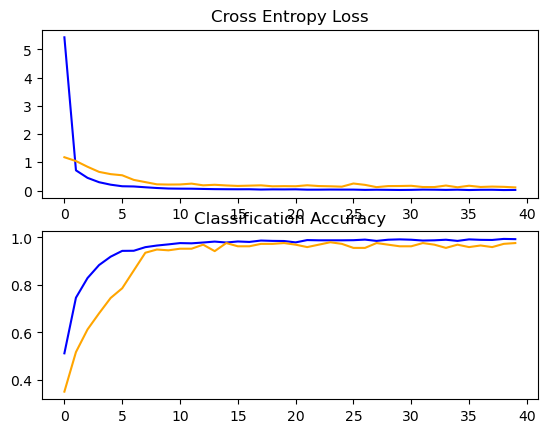

In [9]:
def final_model():
    model = Sequential([
        Rescaling(1./255),
        
    	Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
    	Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation=dense_activation)
    ])

    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

    return model
    
final_model_res = test_harness(final_model(), 40)

## Make Prediction

In [11]:
val_ds = image_dataset_from_directory(
    combined / 'Testing',
    image_size=(img_height, img_width),
    seed=81,
    validation_split=0.21,
    subset="validation",
    shuffle=True,
)

Found 294 files belonging to 3 classes.
Using 61 files for validation.


In [12]:
true_labels = []
preds = []

# Iterate through the dataset
for images, labels in val_ds:
    # Get predictions
    predictions = final_model_res.predict(images)
    
    # Convert predictions from probabilities to class labels
    preds.extend(np.argmax(predictions, axis=1))
    # Convert labels to numpy array
    true_labels.extend(labels.numpy())

# Print results
correct_preds = 0
for i in range(len(true_labels)):
    # Check if prediction is correct
    correct = true_labels[i] == preds[i]
    # Add to count if correct
    if (correct): correct_preds += 1
    # Print results
    print(f"Label: {true_labels[i]}, Prediction: {preds[i]}, Correct: {correct}")

# Print total counts
print(f"\nCorrect: {correct_preds}, False: {len(true_labels) - correct_preds}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
Label: 2, Prediction: 2, Correct: True
Label: 2, Prediction: 2, Correct: True
Label: 2, Prediction: 2, Correct: True
Label: 1, Prediction: 1, Correct: True
Label: 0, Prediction: 0, Correct: True
Label: 1, Prediction: 1, Correct: True
Label: 0, Prediction: 0, Correct: True
Label: 2, Prediction: 2, Correct: True
Label: 1, Prediction: 1, Correct: True
Label: 1, Prediction: 1, Correct: True
Label: 2, Prediction: 2, Correct: True
Label: 0, Prediction: 0, Correct: True
Label: 2, Prediction: 2, Correct: True
Label: 2, Prediction: 2, Correct: True
Label: 2, Prediction: 2, Correct: True
Label: 1, Prediction: 1, Correct: True
Label: 0, Prediction: 0, Correct: True
Label: 1, Prediction: 1, Correct: True
Label: 1, Prediction: 1, Correct: True
Label: 0, Prediction: 0, Correct: True
Label: 0, Prediction: 0, Correct: True
Label: 2, Prediction: 2, Correct: True
Label: 1, Prediction: 1, Correct: True
Label: 0, Prediction: 0, 

2024-10-17 21:37:18.769185: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Save Model

In [10]:
final_model_res.save('final_model_97.keras')